## <b>Style Transfer Tutorial</b>

* 원본 논문: [Image Style Transfer Using Convolutional Neural Networks (CVPR 2016)](https://rn-unison.github.io/articulos/style_transfer.pdf)
* 딥러닝을 활용한 <b>스타일 전송(style transfer)</b> 방법을 처음으로 제안한 논문입니다.
    * 이미지 자체를 업데이트하는 이미지 최적화(optimization) 기법 유형에 해당합니다.
* 소스코드를 실행하기 전에 **[런타임]** - **[런타임 유형 변경]** - **[GPU]**로 설정되어 있는지 확인합니다.
* 논문에서 제시한 파라미터를 완전히 동일하게 따르지는 않으며 핵심 아이디어를 이해하는 목적에 적합한 코드입니다.

#### <b>실습에 필요한 라이브러리 불러오기 및 환경 설정</b>

In [ ]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import PIL
import matplotlib.pyplot as plt

import copy

In [ ]:
# GPU 장치 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 이미지를 불러와 다운받아 텐서(Tensor) 객체로 변환하는 함수
def image_loader(img_path, imsize):
    loader = transforms.Compose([
        transforms.Resize(imsize), # 이미지의 크기를 변경
        transforms.ToTensor() # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
    ])
    image = PIL.Image.open(img_path)
    # 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기


# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)
    plt.show()

In [ ]:
# 저장소의 소스코드를 다운로드하여 실습용 이미지 준비하기
!git clone https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice
%cd Deep-Learning-Paper-Review-and-Practice

Cloning into 'Deep-Learning-Paper-Review-and-Practice'...
remote: Enumerating objects: 462, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 462 (delta 72), reused 190 (delta 65), pack-reused 261
Receiving objects: 100% (462/462), 53.82 MiB | 16.18 MiB/s, done.
Resolving deltas: 100% (152/152), done.
/content/Deep-Learning-Paper-Review-and-Practice


#### <b>Image Reconstruction 실습하기</b>

* 이미지를 최적화(optimization)한다는 것은 특정 손실 값을 낮추는 방향으로 이미지를 업데이트하는 것을 의미합니다.
* MSE 손실(loss)을 이용해 임의의 노이즈(noise)를 특정한 이미지로 변환해 봅시다.

#### <b>CNN 네트워크 불러오기</b>

* 특징 추출기(feature extractor)로 VGG 네트워크를 사용합니다.

In [ ]:
# 뉴럴 네트워크 모델을 불러옵니다.
cnn = models.vgg19(pretrained=True).features.to(device).eval()
print(cnn)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 123MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# 입력 정규화(Normalization)를 위한 초기화
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

#### <b>Style Reconstruction 실습하기</b>

* 임의의 노이즈(noise)가 특정한 이미지의 스타일을 가지도록 변환합니다.
* style_layers 리스트 변수의 값을 조절하여 어떤 레이어를 이용할지 설정할 수 있습니다.

In [ ]:
def gram_matrix(input):
    # a는 배치 크기, b는 특징 맵의 개수, (c, d)는 특징 맵의 차원을 의미
    a, b, c, d = input.size()
    # 논문에서는 i = 특징 맵의 개수, j = 각 위치(position)
    features = input.view(a * b, c * d)
    # 행렬 곱으로 한 번에 Gram 내적 계산 가능
    G = torch.mm(features, features.t())
    # Normalize 목적으로 값 나누기
    return G.div(a * b * c * d)


# 스타일 손실(style loss) 계산을 위한 클래스 정의
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
# 콘텐츠 손실(content loss) 계산을 위한 클래스 정의
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']

# Style Transfer 손실(loss)을 계산하는 함수
def get_losses(cnn, content_img, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses, style_losses

[ Content Image ]


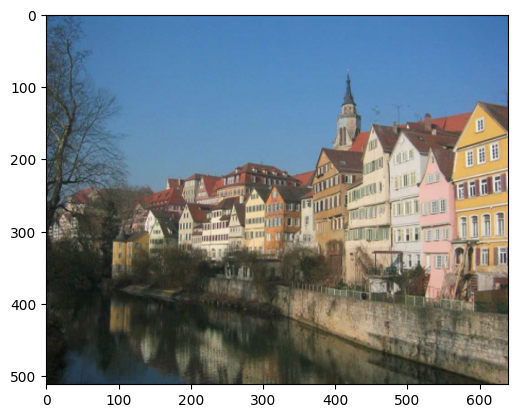

[ Style Image ]


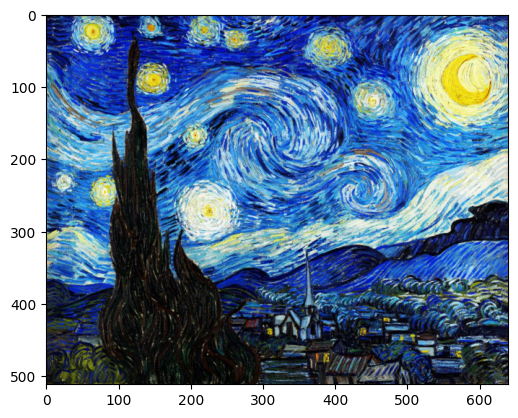

In [ ]:
# 콘텐츠(Content) 이미지와 스타일(Style) 이미지를 모두 준비합니다.
content_img = image_loader('./code_practices/images/content_img_1.jpg', (512, 640))
style_img = image_loader('./code_practices/images/style_img_1.jpg', (512, 640))

plt.style.use("default")
print("[ Content Image ]")
imshow(content_img)
print("[ Style Image ]")
imshow(style_img)

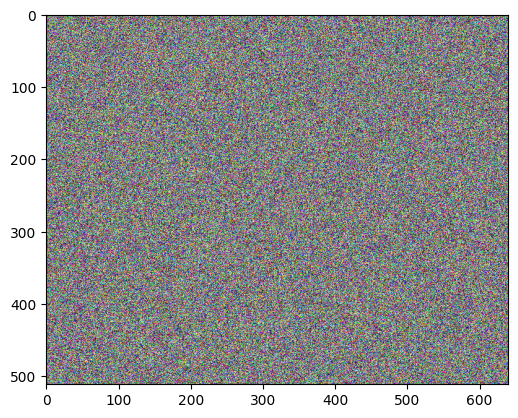

In [ ]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

In [ ]:
training_loss_LBFGS = []

def style_transfer(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses(cnn, content_img, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e5
            loss = content_score + style_score
            loss.backward()
            training_loss_LBFGS.append(round(loss.item(),4))

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return content_score + style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
# style transfer 수행 - LBFGS
output = style_transfer(cnn, content_img=content_img, style_img=style_img, input_img=input_img, iters=900)

Text(0, 0.5, 'total loss in log scale')

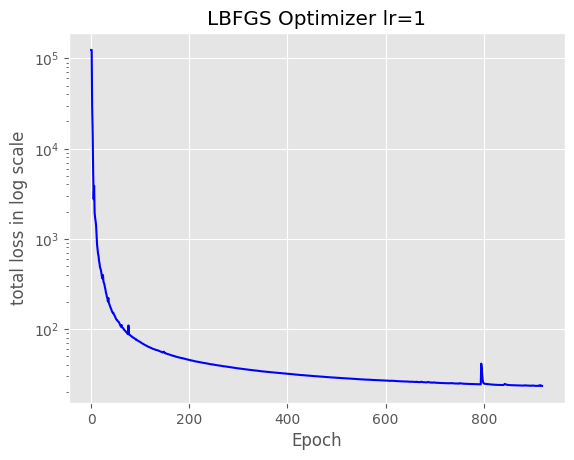

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.title("LBFGS Optimizer lr=1")
plt.plot(np.array(range(0,920)), training_loss_LBFGS, color='blue')
plt.yscale('log', base=10)
plt.xlabel('Epoch')
plt.ylabel('total loss in log scale')

# **Style Layer 사용 수 비교**

깊은 레이어까지 잘 사용할 때 style 잘 따라가고 이미지에 포함된 실질적인 object들의 배치와 같은 것들은 무시됨

**conv1_1, conv2_1**

In [ ]:
# 1,3 사용

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_3']

# Style Transfer 손실(loss)을 계산하는 함수
def get_losses_2(cnn, content_img, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses, style_losses

In [ ]:
def style_transfer(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses_2(cnn, content_img, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e5
            loss = content_score + style_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return content_score + style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

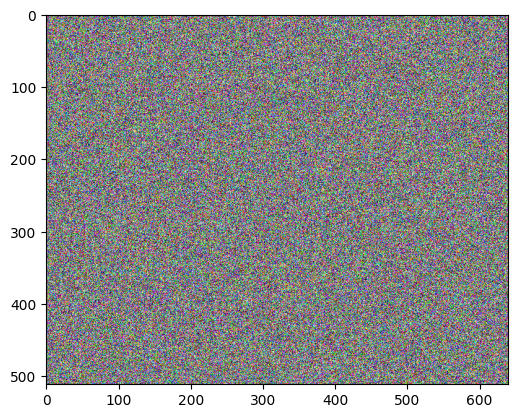

In [ ]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
plt.style.use("default")
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

In [ ]:
output = style_transfer(cnn, content_img=content_img, style_img=style_img, input_img=input_img, iters=1000)

**conv1_1, conv2_1, conv3_1**

In [ ]:
# 1,3,5 사용

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_3', 'conv_5']

# Style Transfer 손실(loss)을 계산하는 함수
def get_losses_3(cnn, content_img, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses, style_losses

In [ ]:
def style_transfer(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses_3(cnn, content_img, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e5
            loss = content_score + style_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return content_score + style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

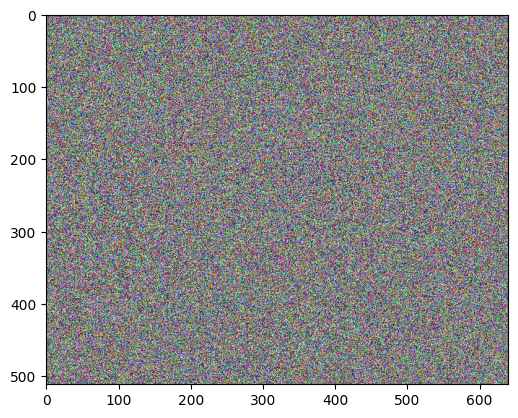

In [ ]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
plt.style.use("default")
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

In [ ]:
output = style_transfer(cnn, content_img=content_img, style_img=style_img, input_img=input_img, iters=1000)

**conv1_1, conv2_1, conv3_1, conv4_1**

In [ ]:
# 1,3,5,7 사용

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9']

# Style Transfer 손실(loss)을 계산하는 함수
def get_losses_4(cnn, content_img, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses, style_losses

In [ ]:
def style_transfer(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses_4(cnn, content_img, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e5
            loss = content_score + style_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return content_score + style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

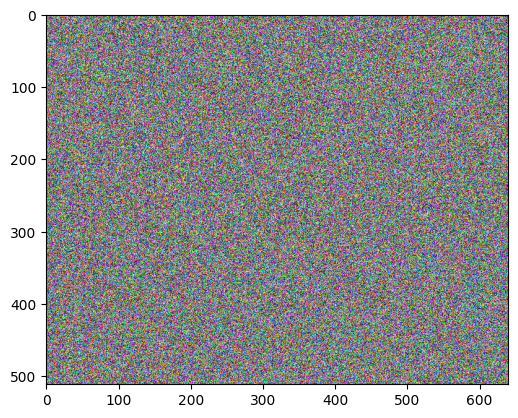

In [ ]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
plt.style.use("default")
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

In [ ]:
output = style_transfer(cnn, content_img=content_img, style_img=style_img, input_img=input_img, iters=900)

# **Adam Optimizer 사용**
lr = 0.01, 0.05

[ Content Image ]


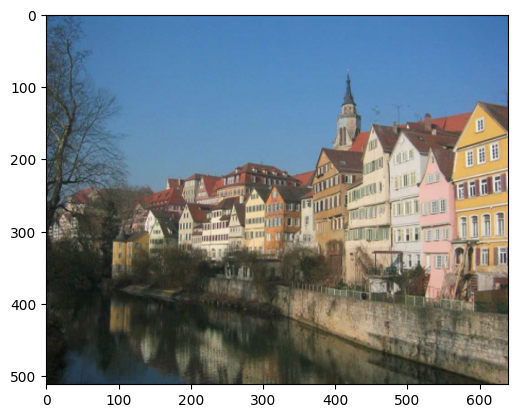

[ Style Image ]


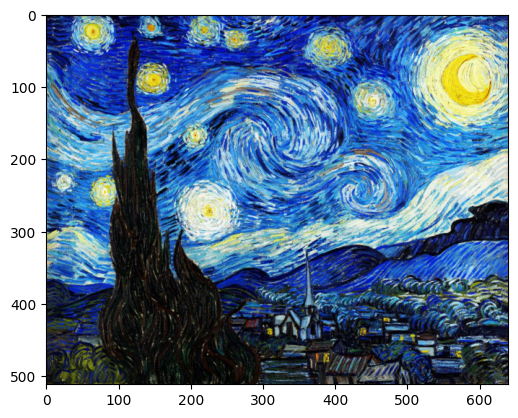

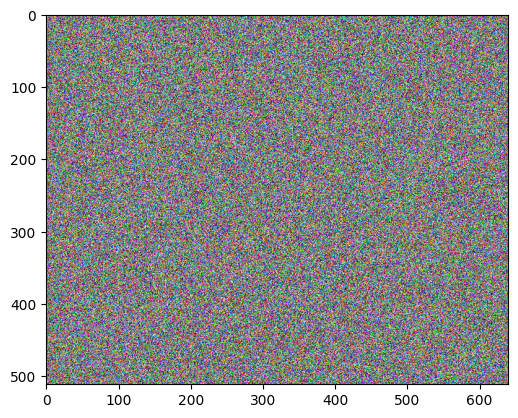

In [ ]:
# 콘텐츠(Content) 이미지와 스타일(Style) 이미지를 모두 준비합니다.
content_img = image_loader('./code_practices/images/content_img_1.jpg', (512, 640))
style_img = image_loader('./code_practices/images/style_img_1.jpg', (512, 640))

plt.style.use("default")
print("[ Content Image ]")
imshow(content_img)
print("[ Style Image ]")
imshow(style_img)

input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

In [ ]:
Adam_1 = []

def style_transfer1(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses(cnn, content_img, style_img, input_img)
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.01)

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e5
            loss = content_score + style_score
            loss.backward()
            Adam_1.append(round(loss.item(),4))

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return content_score + style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
# lr = 0.01
output = style_transfer1(cnn, content_img=content_img, style_img=style_img, input_img=input_img, iters=1800)

Text(0, 0.5, 'Total Loss(Content Loss+Style Loss)')

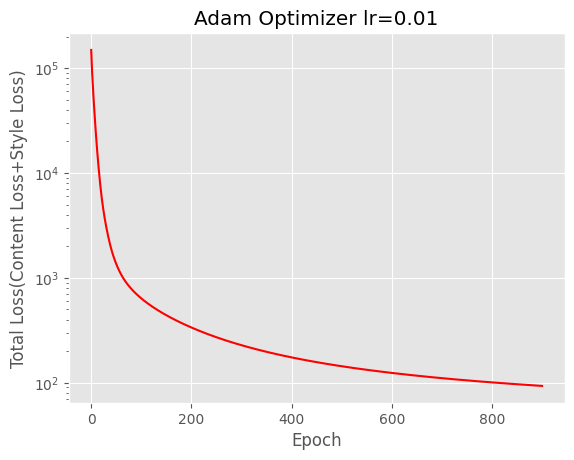

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.title("Adam Optimizer lr=0.01")
plt.plot(np.array(range(0,901)), Adam_1, color='red')
plt.yscale('log', base=10)
plt.xlabel('Epoch')
plt.ylabel('Total Loss(Content Loss+Style Loss)')

In [ ]:
Adam_3 = []

def style_transfer3(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses(cnn, content_img, style_img, input_img)
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.05)

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e5
            loss = content_score + style_score
            loss.backward()
            Adam_3.append(round(loss.item(),4))

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return content_score + style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
# lr = 0.05, iter = 1800
output = style_transfer3(cnn, content_img=content_img, style_img=style_img, input_img=input_img, iters=900)

Text(0, 0.5, 'log scale of total loss')

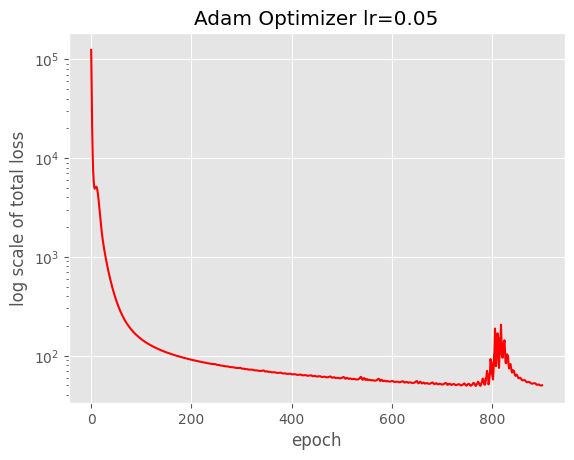

In [ ]:
plt.style.use('ggplot')
plt.title("Adam Optimizer lr=0.05")
plt.plot(np.array(range(0,901)), Adam_3, color='red')
plt.yscale('log', base=10)
plt.xlabel('epoch')
plt.ylabel('log scale of total loss')

In [ ]:
# lr = 0.05
output = style_transfer3(cnn, content_img=content_img, style_img=style_img, input_img=input_img, iters=2500)

Text(0, 0.5, 'log scale of total loss')

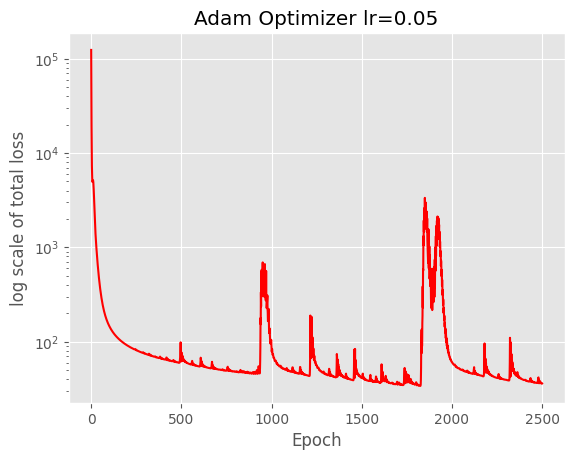

In [ ]:
plt.style.use('ggplot')
plt.title("Adam Optimizer lr=0.05")
plt.plot(np.array(range(0,2501)), Adam_3, color='red')
plt.yscale('log', base=10)
plt.xlabel('Epoch')
plt.ylabel('log scale of total loss')

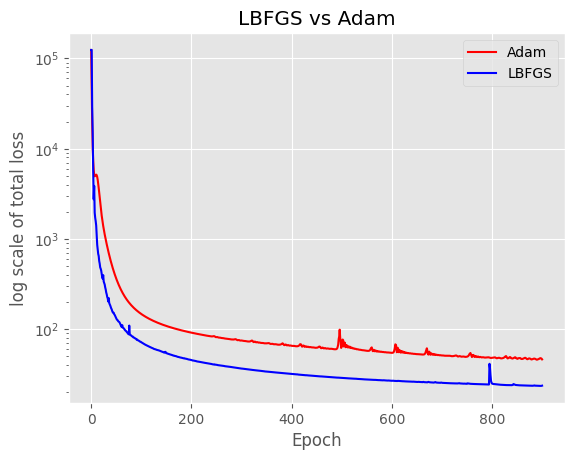

In [ ]:
plt.style.use('ggplot')
plt.title("LBFGS vs Adam")
plt.plot(np.array(range(0,901)), Adam_3[:901], color='red', label='Adam')
plt.plot(np.array(range(0,901)), training_loss_LBFGS[:901], color='blue', label='LBFGS')
plt.yscale('log', base=10)
plt.xlabel('Epoch')
plt.ylabel('log scale of total loss')
plt.legend()